In [385]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.linalg import solve_continuous_lyapunov
import matplotlib.pyplot as plt

a0 = -1
a1 = 1
b0 = 2

A = np.array([[0, 1],
              [-a0, -a1]])
b = np.array([[0.0],
              [b0]])

am0, am1 = 256.0, 32.0
Am = np.array([[0, 1],
               [-am0, -am1]])
bm = np.array([[0.0],
               [am0]])

theta = np.array([[(a0 - am0)/b0],
                  [(a1 - am1)/b0]])

kappa = b0 / am0
Q = np.eye(2)
P = solve_continuous_lyapunov(Am.T, -Q)


In [386]:
'ПРИБРАТЬСЯ В НАЗВАНИЯХ ДУБЛИРОВАННЫХ ФУНКЦИЙ!'


def get_g(t):
    return np.sign(np.sin(0.5 * t)) + 2

def control_u(x, theta_hat, g, kappa):
    """Закон управления"""
    # return float(theta_hat.T @ x + g / kappa)

    # return     float((theta_hat.T @ x + g / kappa)[0])
    return theta_hat.T @ x + g / kappa


def get_u_not_adapt(x, theta, g, kappa):
    # Убедимся, что theta имеет правильную форму для умножения
    theta = theta.reshape(-1)  # преобразуем в одномерный массив формы (2,)
    
    # Вычисляем скалярное произведение для каждой строки x
    dot_product = np.sum(x * theta, axis=1)
    
    # Убедимся, что g имеет правильную форму
    if g.ndim > 1:
        g = g.flatten()
    
    return dot_product + g / kappa

def theta_hat_dot_func(x, xm, P, b):
    """Закон адаптации"""
    gamma = 1
    e = xm - x
    # e = x - xm
    return gamma * x @ (b.T @ P @ e)
    # return -gamma * x @ (b.T @ P @ e)


In [387]:
def get_y(C, x):
    return C @ x

def get_x_dot(A, x, B, u):
    return A @ x + B @ u

def get_xm_dot(Am, xm, bm, g):
    return Am @ xm + bm @ g

In [388]:
t_span = (0, 0.5)
t = np.linspace(t_span[0], t_span[1], 1000)
g = get_g(t)

# y0 = np.zeros(6)
# x = state[0:2].reshape(2, 1)
# xm = state[2:4].reshape(2, 1)
# # theta_hat = state[4:6].reshape(2, 1)


# get_xm_dot(Am, x, bm, g)

In [389]:
def closed_loop(t, state):
    """
    state = [x(2), xm(2), theta_hat(2)]
    """
    x = state[0:2].reshape(2, 1)
    xm = state[2:4].reshape(2, 1)
    theta_hat = state[4:6].reshape(2, 1)

    g = get_g(t)
    u = control_u(x, theta_hat, g, kappa)

    x_dot = A @ x + b * u
    # ПРОВЕРИТЬ МАТРИЦУ g ДОЛЖНА ЛИ ОНА БЫТЬ СКАЛЯРОМ ИЛИ УМНОЖАТЬ НАДО НА МАТРИЦУ
    xm_dot = Am @ xm + bm * g
    theta_hat_dot = theta_hat_dot_func(x, xm, P, b)

    return np.vstack((x_dot, xm_dot, theta_hat_dot)).flatten()


In [390]:
# начальные условия: все нули
y0 = np.zeros(6)
sol = solve_ivp(closed_loop, t_span, y0,
                method='RK45', max_step=0.01, dense_output=True)
Y = sol.sol(t).T    # shape: (N,6)

x = Y[:, 0:2]
xm = Y[:, 2:4]        
theta_hat = Y[:, 4:6]

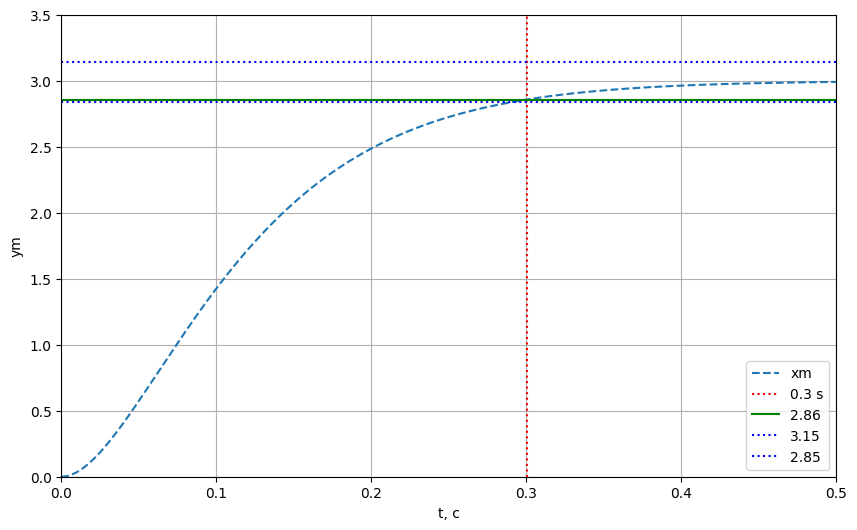

In [391]:
plt.figure(figsize=(10,6))
plt.ylim(top=3.5)
plt.xlim(right=t_span[1])
plt.plot(t, xm[:,0], '--', label='xm')

x_value = xm[600, 0]  # Значение x[300, 0]
t_value = t[600]     # Соответствующее значение времени

plt.axvline(x=t_value, color='r', linestyle=':', label=f'0.3 s')
plt.axhline(y=x_value, color='g', linestyle='-', label=f'{x_value:.2f}')

plt.axhline(y=float(xm[-1][0])*1.05, color='b', linestyle=':', label='3.15')
plt.axhline(y=float(xm[-1][0])*0.95, color='b', linestyle=':', label='2.85')


# plt.title("Состояние эталонной модели")
plt.xlabel("t, c")
plt.ylabel("ym")
plt.legend()
plt.grid()


plt.show()

In [392]:
theta

array([[-128.5],
       [ -15.5]])

In [393]:
u_not_adapt = get_u_not_adapt(x, theta, g, kappa)

Написать функцию для ВСВ и получения x по u
Построить график

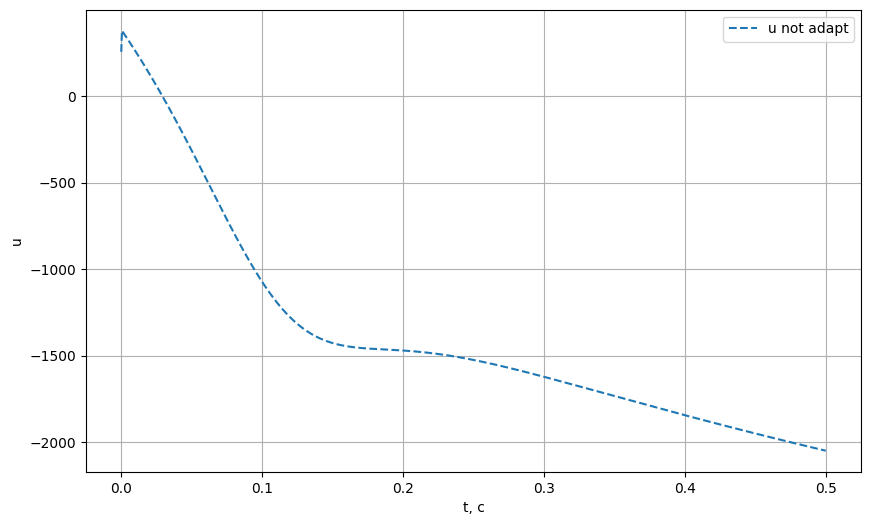

In [394]:
plt.figure(figsize=(10,6))
# plt.ylim(top=3.5)
# plt.xlim(right=t_span[1])
plt.plot(t, u_not_adapt, '--', label='u not adapt')

# plt.title("Состояние эталонной модели")
plt.xlabel("t, c")
plt.ylabel("u")
plt.legend()
plt.grid()


plt.show()

# 2 Моделирование системы с неадаптивным регулятором

In [395]:
theta = np.array([-128.5, -15.5]) # Расчетные параметры theta
# theta = np.array([-192.5, -23.5]) # Незначительно отклонить параметры
# theta = np.array([-2.0, 1.0]) # Значительно отклонить параметры

In [396]:
def closed_loop_not_adapt(t, state):
    """
    state = [x(2), xm(2)]
    """
    x = state[0:2].reshape(2, 1)
    xm = state[2:4].reshape(2, 1)

    g = get_g(t)  # скаляр
    u = float(theta @ x.flatten() + g / kappa)

    x_dot = A @ x + b * u
    # x_dot = get_x_dot(A, x, b, u)
    xm_dot = Am @ xm + bm * g
    # xm_dot = get_xm_dot(Am, xm, bm, g)

    return np.vstack((x_dot, xm_dot)).flatten()

In [397]:
t_span = (0, 200)
t = np.linspace(t_span[0], t_span[1], 1000)

y0 = np.zeros(4)               # x и xm
sol = solve_ivp(closed_loop_not_adapt, t_span, y0,
                method='RK45', max_step=0.01, dense_output=True)

t_grid = np.linspace(t_span[0], t_span[1], 1000)
Y = sol.sol(t_grid).T

x = Y[:, 0:2]
xm = Y[:, 2:4]

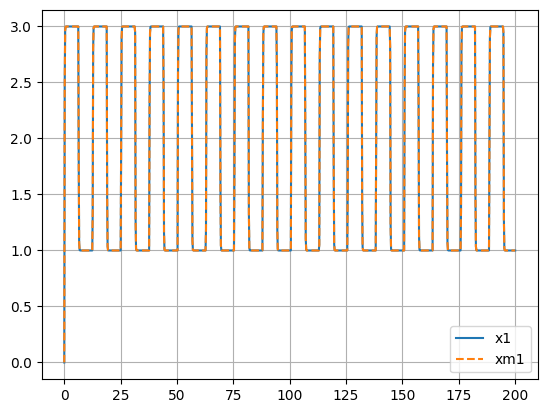

In [398]:
plt.plot(t_grid, x[:,0], label='x1')
plt.plot(t_grid, xm[:,0], '--', label='xm1')
plt.grid(); plt.legend(); plt.show()

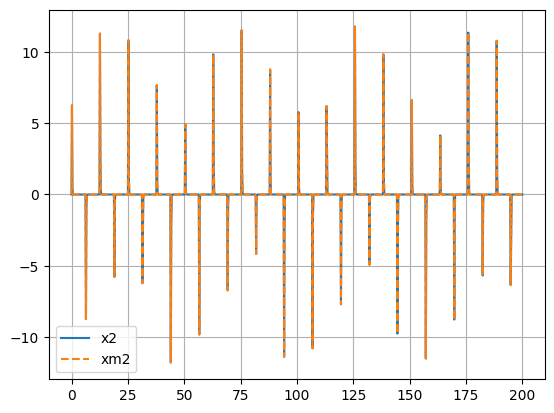

In [399]:
plt.plot(t_grid, x[:,1], label='x2')
plt.plot(t_grid, xm[:,1], '--', label='xm2')
plt.grid(); plt.legend(); plt.show()

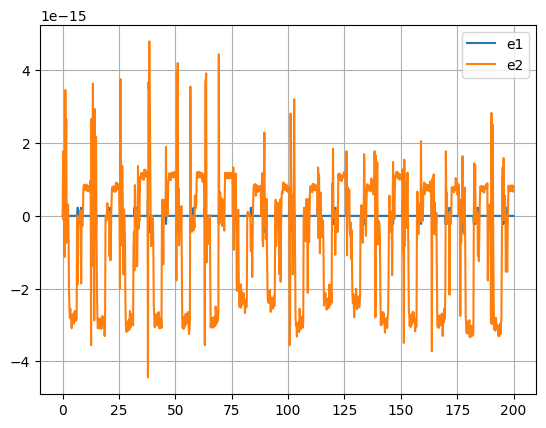

In [400]:
e = x - xm
plt.plot(t_grid, e[:,0], label='e1')
plt.plot(t_grid, e[:,1], label='e2')
plt.grid(); plt.legend(); plt.show()

# 3. Моделирование адаптивной системы

In [401]:
"""
adaptive_experiments.py

Выполняет моделирование адаптивной системы:
 u = theta_hat^T x + g/kappa
 theta_hat_dot = gamma * x * (b^T P e)

Проводит:
 1) три эксперимента при фиксированном gamma (разные x(0))
 2) три эксперимента при разных gamma (разные скорости адаптации)
 3) один эксперимент с тем же набором при g(t) = 1

Построение: для каждого эксперимента 3 графика:
 - x(t) и xm(t) на одном графике
 - e(t) = x - xm
 - theta_tilde(t) = theta - theta_hat
"""

# ---------------- Параметры системы ----------------
# A = np.array([[0.0, 1.0],
#               [1.0, -1.0]])   # задано
# b0 = 2.0
# b = np.array([0.0, b0])

# # каноническое соответствие: A = [[0,1],[-a0,-a1]]
# a0 = -A[1,0]   # = -1 -> a0 = -1 in earlier formulation (but computed from A)
# a1 = -A[1,1]   # = 1

# # Эталонная модель: выбираем фактор (4.8 в методичке -> wn = 4.8 / tn)
# tn = 0.3


# factor = 4.8   # можно заменить на 4.0 или 4.6 для сравнения

# zeta = 1.0
# wn = factor / tn
# am0 = wn**2
# am1 = 2*zeta*wn

# Am = np.array([[0.0, 1.0],
#                [-am0, -am1]])
# bm = np.array([0.0, am0])

# # вычисление истинного theta (формула из задания)
# theta = np.array([(a0 - am0)/b0, (a1 - am1)/b0])
# kappa = b0 / am0

# Q = np.eye(2)
# # Lyapunov: Am'.P + P.Am = -Q  -> use solve_continuous_lyapunov(Am.T, Q)
# P = solve_continuous_lyapunov(Am.T, Q)


'\nadaptive_experiments.py\n\nВыполняет моделирование адаптивной системы:\n u = theta_hat^T x + g/kappa\n theta_hat_dot = gamma * x * (b^T P e)\n\nПроводит:\n 1) три эксперимента при фиксированном gamma (разные x(0))\n 2) три эксперимента при разных gamma (разные скорости адаптации)\n 3) один эксперимент с тем же набором при g(t) = 1\n\nПостроение: для каждого эксперимента 3 графика:\n - x(t) и xm(t) на одном графике\n - e(t) = x - xm\n - theta_tilde(t) = theta - theta_hat\n'

In [402]:
# ---------------- Сигналы ----------------
def g_time(t):
    """Исходный g(t) из задания: cos t + 3 sin 2t + 5"""
    return np.cos(t) + 3.0*np.sin(2.0*t) + 5.0

def g_const(t):
    return 1.0

In [403]:
# ---------------- Законы управления и адаптации ----------------
def theta_hat_dot_func(x, xm, P, b, gamma):
    """theta_hat_dot = gamma * x * (b^T P e)   (elementwise)"""
    e = xm - x
    # scalar = float(np.dot(b, P.dot(e)))   # b^T P e -> scalar
    scalar = float(np.dot(b.ravel(), P @ e))
    return gamma * x * scalar              # vector length 2

In [404]:
def make_closed_loop(A, b, Am, bm, P, kappa, gamma, get_g):
    def closed_loop(t, state):
        # state: [x0,x1, xm0,xm1, th0,th1]
        x = state[0:2]
        xm = state[2:4]
        theta_hat = state[4:6]
        g = float(get_g(t))
        u = control_u(x, theta_hat, g, kappa)
        # x_dot = A.dot(x) + b * u
        x_dot = A.dot(x) + b.ravel() * u
        # xm_dot = Am.dot(xm) + bm * g
        xm_dot = Am.dot(xm) + bm.ravel() * g
        theta_hat_dot = theta_hat_dot_func(x, xm, P, b, gamma)

        if np.any(np.isnan(x_dot)) or np.any(np.isinf(x_dot)):
            raise ValueError("NaN/inf in x_dot")


        # отладка: проверим нет ли nan/inf и каковы масштабы
        for name, arr in zip(["x_dot", "xm_dot", "theta_hat_dot"],
                             [x_dot, xm_dot, theta_hat_dot]):
            if np.any(~np.isfinite(arr)):
                raise ValueError(f"{name} содержит nan/inf при t={t}, y={y}")
            if np.max(np.abs(arr)) > 1e6:
                raise ValueError(f"{name} слишком велик: {arr}")
            
        
        return np.concatenate([x_dot, xm_dot, theta_hat_dot])
    return closed_loop

In [405]:
# ---------------- Симуляция ----------------
def simulate(closed_loop_fun, y0, t_span=(0,16), t_eval=None):
    if t_eval is None:
        t_eval = np.linspace(t_span[0], t_span[1], 2000)
    sol = solve_ivp(closed_loop_fun, t_span, y0, t_eval=t_eval, max_step=0.01)
    if not sol.success:
        raise RuntimeError("Integration failed: " + sol.message)
    return sol.t, sol.y.T

In [406]:
# ---------------- Эксперименты ----------------
tspan = (0.0, 5.0)
# tspan = (0.0, 0.5)
# t_eval = np.linspace(*tspan, 2000)
t_eval = np.linspace(*tspan, 10000)

results = []

In [407]:
# (1) три эксперимента при фиксированном gamma (gamma=1) с разными x(0)
# gamma_fixed = 1.0
gamma_fixed = 1500.0

init_xs = [np.array([0.0, 0.0]), np.array([1.0, 0.0]), np.array([0.0, 1.0])]
for idx, x0 in enumerate(init_xs, start=1):
    y0 = np.zeros(6)
    y0[0:2] = x0
    closed = make_closed_loop(A, b, Am, bm, P, kappa, gamma_fixed, g_time)
    t, Y = simulate(closed, y0, t_span=tspan, t_eval=t_eval)
    results.append((f"fixed_gamma_run{idx}", gamma_fixed, g_time, t, Y))

# (2) три эксперимента при разных gamma (gamma in [0.1,1,10]) с нулевым x(0)
gamma_list = [0.1, 1.0, 10.0]
for gamma in gamma_list:
    y0 = np.zeros(6)
    closed = make_closed_loop(A, b, Am, bm, P, kappa, gamma, g_time)
    t, Y = simulate(closed, y0, t_span=tspan, t_eval=t_eval)
    results.append((f"gamma_{gamma}", gamma, g_time, t, Y))

# (3) один эксперимент (gamma=1) при g(t) = 1 (константа)
y0 = np.zeros(6)
closed = make_closed_loop(A, b, Am, bm, P, kappa, gamma_fixed, g_const)
t, Y = simulate(closed, y0, t_span=tspan, t_eval=t_eval)
results.append(("const_g_gamma1", gamma_fixed, g_const, t, Y))

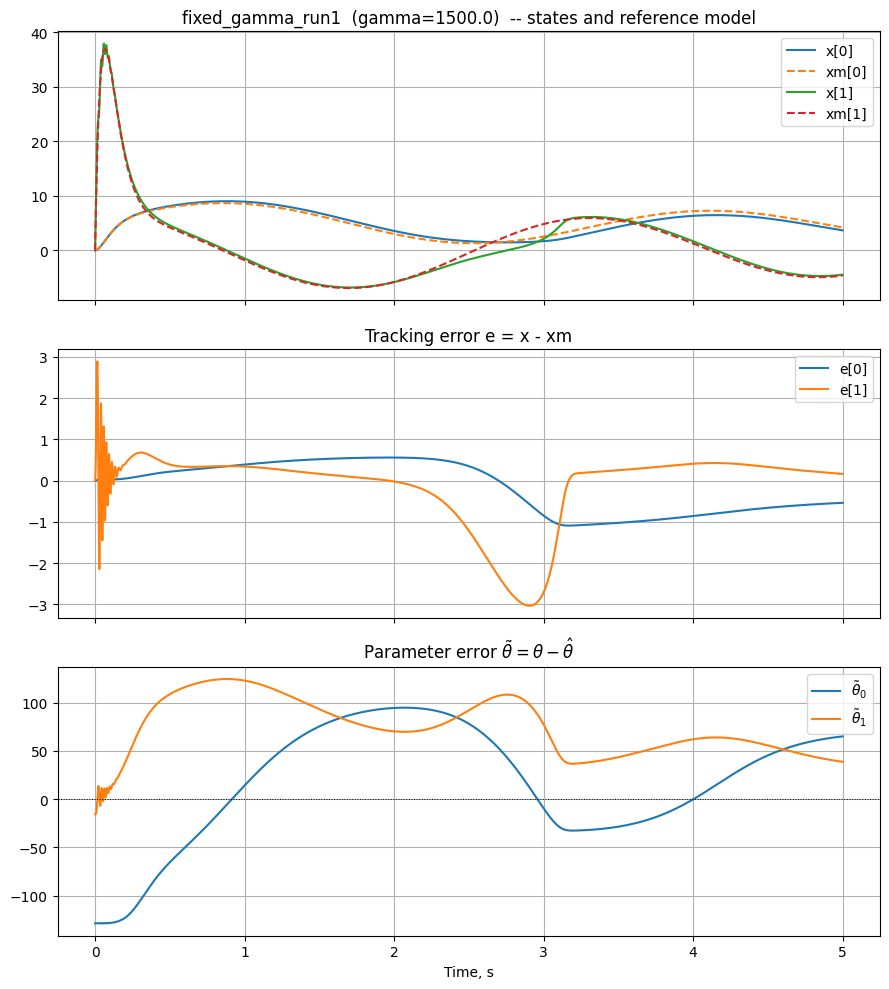

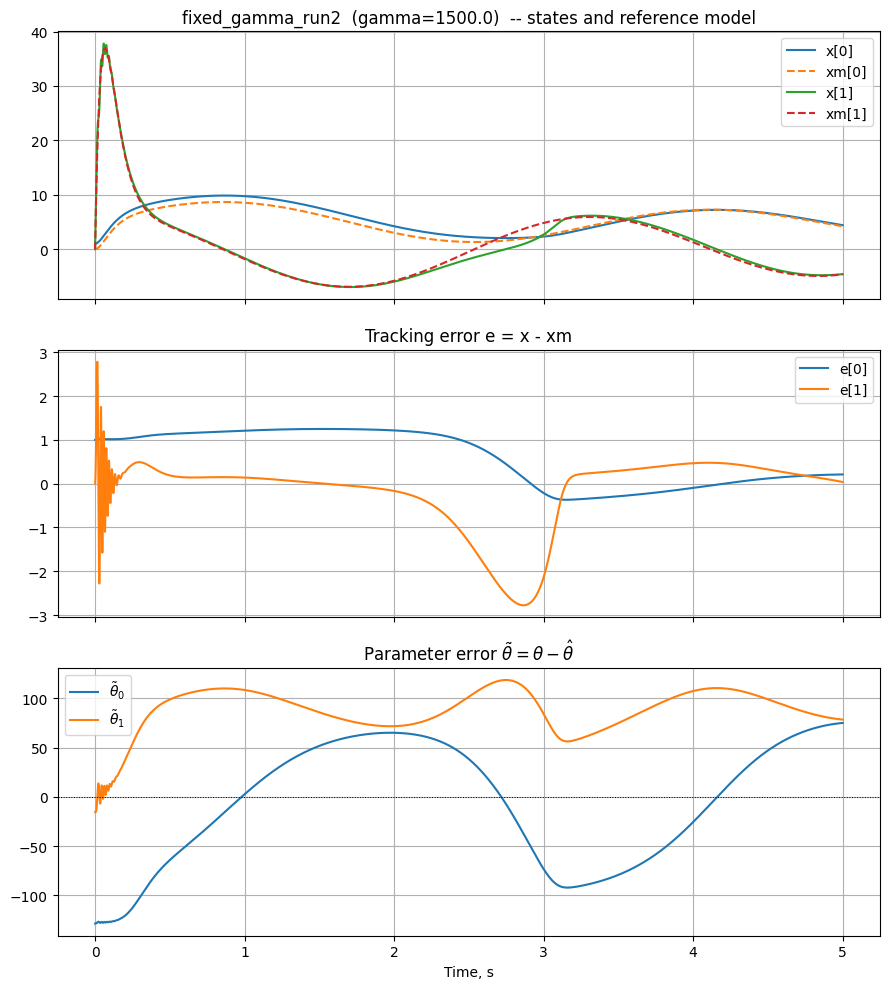

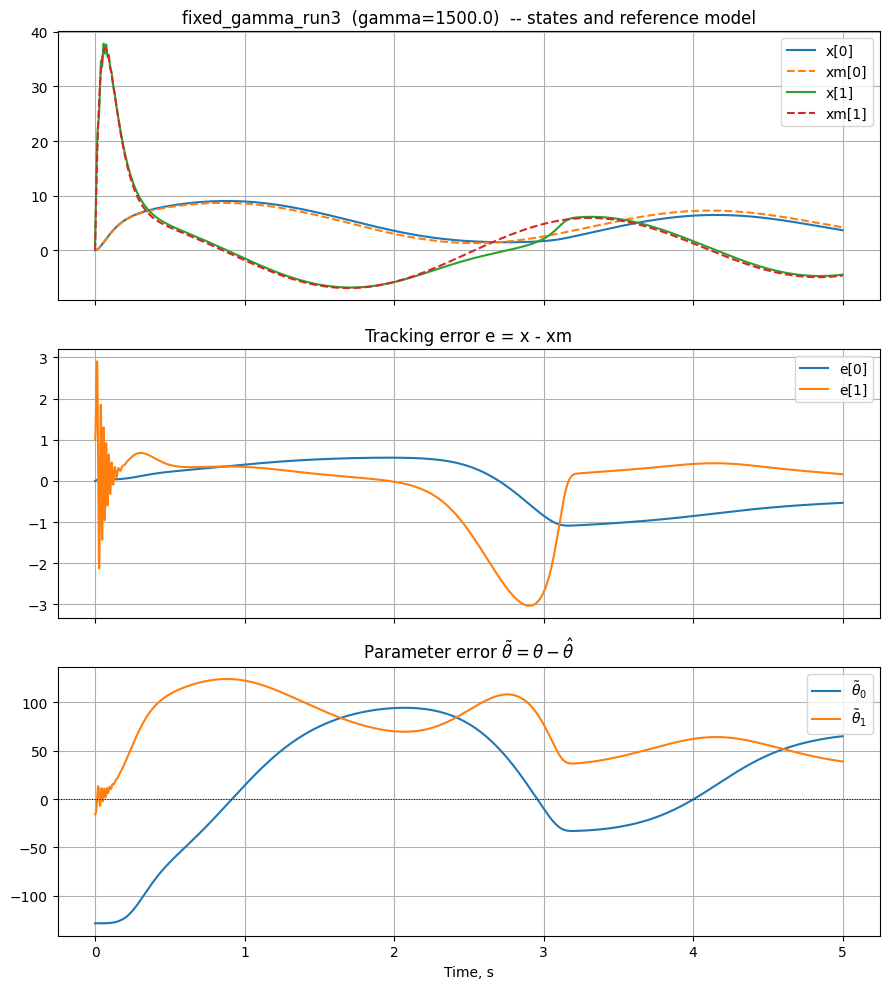

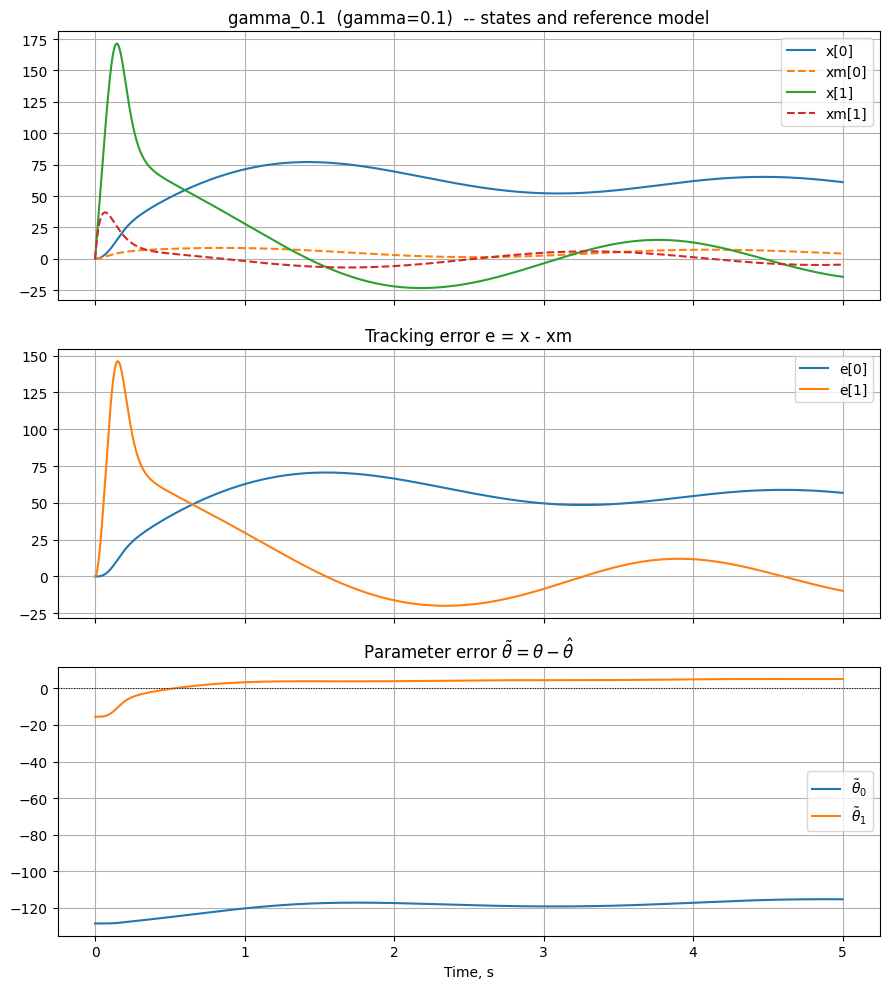

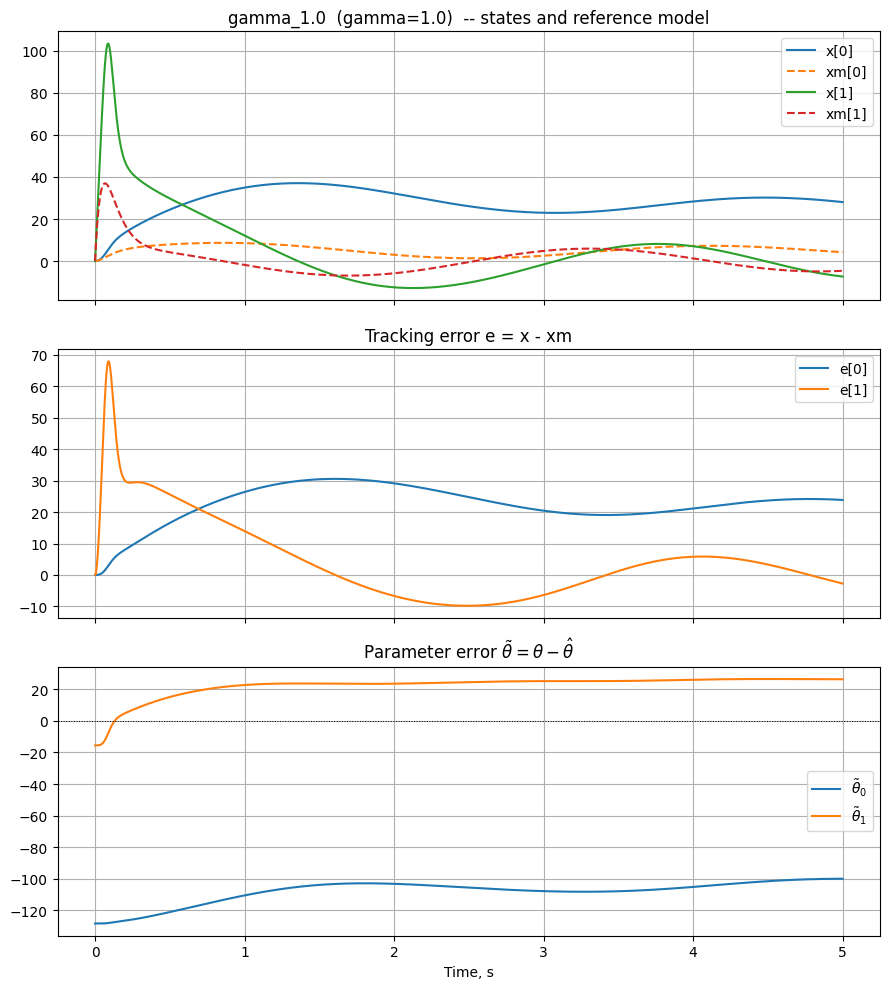

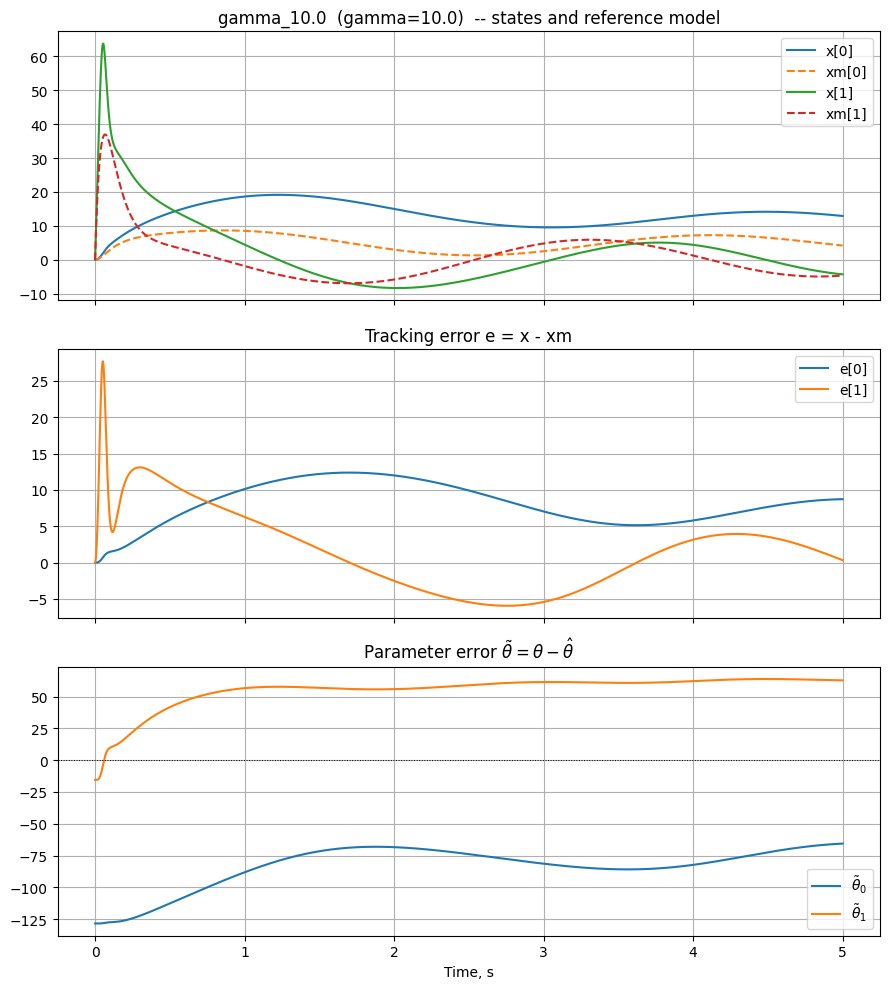

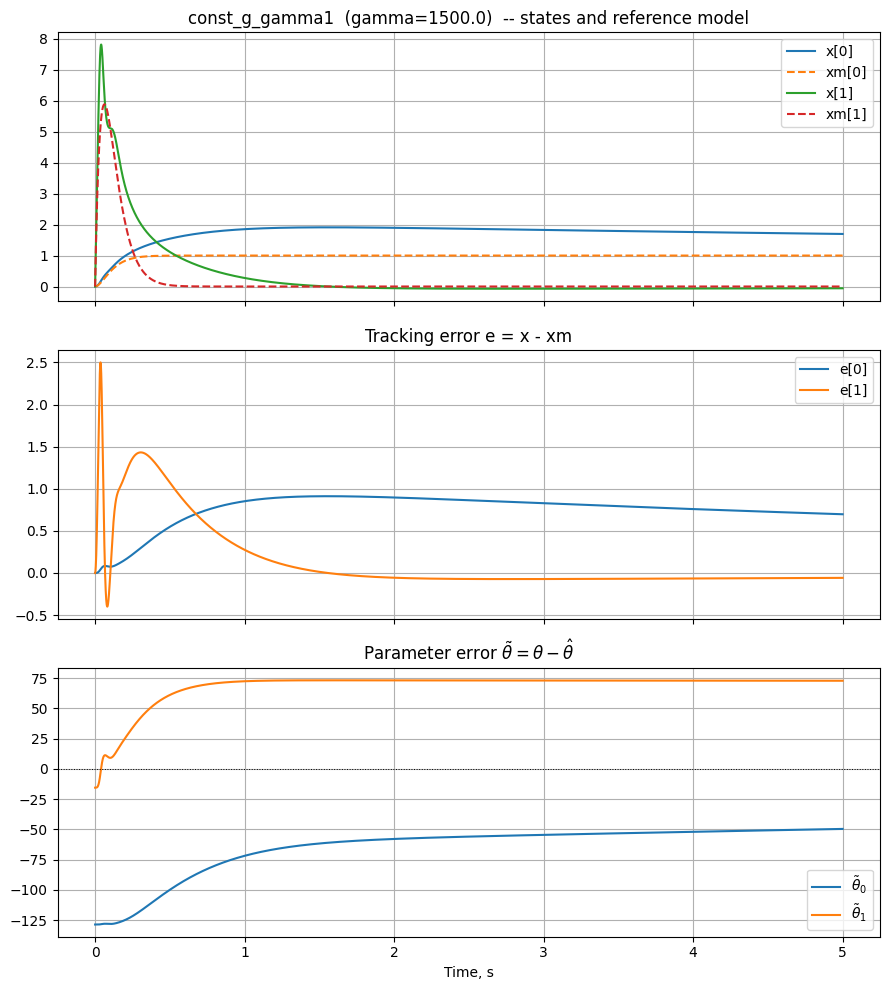

Done. Experiments run: ['fixed_gamma_run1', 'fixed_gamma_run2', 'fixed_gamma_run3', 'gamma_0.1', 'gamma_1.0', 'gamma_10.0', 'const_g_gamma1']


In [408]:
# ---------------- Визуализация результатов ----------------
def plot_experiment(name, gamma, t, Y):
    x = Y[:, 0:2]
    xm = Y[:, 2:4]
    theta_hat = Y[:, 4:6]
    theta_tilde = np.tile(theta, (len(t),1)) - theta_hat
    e = x - xm

    fig, axs = plt.subplots(3, 1, figsize=(9,10), sharex=True)
    axs[0].plot(t, x[:,0], label='x[0]'); axs[0].plot(t, xm[:,0], '--', label='xm[0]')
    axs[0].plot(t, x[:,1], label='x[1]'); axs[0].plot(t, xm[:,1], '--', label='xm[1]')
    axs[0].set_title(f"{name}  (gamma={gamma})  -- states and reference model")
    axs[0].legend(); axs[0].grid(True)

    axs[1].plot(t, e[:,0], label='e[0]'); axs[1].plot(t, e[:,1], label='e[1]')
    axs[1].set_title("Tracking error e = x - xm")
    axs[1].legend(); axs[1].grid(True)

    axs[2].plot(t, theta_tilde[:,0], label=r'$\tilde{\theta}_0$'); axs[2].plot(t, theta_tilde[:,1], label=r'$\tilde{\theta}_1$')
    axs[2].axhline(0, color='k', linestyle=':', linewidth=0.7)
    axs[2].set_title(r'Parameter error $\tilde{\theta} = \theta - \hat{\theta}$')
    axs[2].legend(); axs[2].grid(True)

    plt.xlabel("Time, s")
    plt.tight_layout()
    plt.show()

# Plot all results
for (name, gamma, gfun, t, Y) in results:
    plot_experiment(name, gamma, t, Y)

print("Done. Experiments run:", [r[0] for r in results])
